In [1]:
import cv2
from matplotlib import pyplot as plt
import os

import numpy as np

In [2]:
path_imgs = "imgs"
path_labels = "imgs/labels"

clean_img_name = "1660021200.jpg"

# Get all the names of the images
imgs = os.listdir(path_imgs) # List of all the images in the folder

labels = os.listdir(path_labels) # List of all the labels in the folder

# Sort the lists
imgs.sort()
labels.sort()

if ".DS_Store" in imgs:
    imgs.pop(imgs.index(".DS_Store"))

if ".DS_Store" in labels:
    labels.pop(labels.index(".DS_Store"))

# Read the labels
imgs_with_labels = {}
for label_name in labels:
    with open(path_labels + "/" + label_name, "r") as f:
        img_name = label_name[:-4] + ".jpg"
        imgs_with_labels[img_name] = []
        for line in f:
            line = line.strip().split(",")
            label_name = line[0]
            label_x = line[1]
            label_y = line[2]
            img_name = line[3]

            if img_name not in imgs:
                continue

            label = {
                "label_name": label_name,
                "label_x": int(label_x),
                "label_y": int(label_y)
            }

            if img_name in imgs_with_labels:
                imgs_with_labels[img_name].append(label)

---
In this case, we will define the functions we need for the different tests.

We will define the absolute difference between two images.
Remove the part of the image that we don't want to analyse because it is the background.

In [3]:
def calculate_image_difference(path_imgs, img_name, clean_img_name):
    """
    Calculates the absolute difference between a grayscale image and its clean version.

    Parameters:
    - path_imgs (str): Path to the directory containing the images.
    - img_name (str): Name of the original image file.
    - clean_img_name (str): Name of the clean image file.

    Returns:
    - diff (numpy.ndarray): The absolute difference between the two images in grayscale.
    """
    # Load the original image and convert it to grayscale
    img = cv2.imread(os.path.join(path_imgs, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Load the clean image and convert it to grayscale
    clean_img = cv2.imread(os.path.join(path_imgs, clean_img_name))
    clean_img = cv2.cvtColor(clean_img, cv2.COLOR_BGR2GRAY)

    # Calculate the absolute difference
    diff = cv2.absdiff(img, clean_img)

    return diff

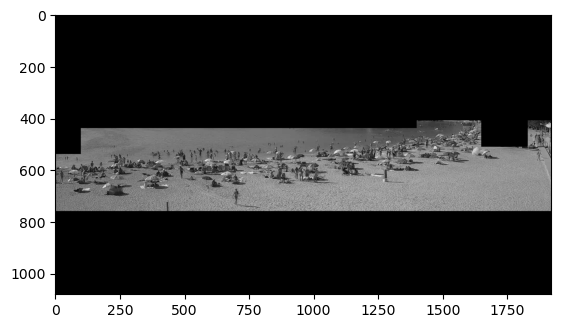

In [4]:
def remove_background(img, pixel = 0):
    """
    Removes specific regions of an image to create a new version without the background.

    Parameters:
    - img (numpy.ndarray): The input image, which must be in grayscale format.
    - pixel (int, optional): The pixel value used to "mask" the removed background areas. Default is 0 (black).

    Returns:
    - new_img (numpy.ndarray): A copy of the input image with the specified regions set to the `pixel` value.
    
    Notes:
    - This function is designed for grayscale images (`img` must already be converted to grayscale before calling).
    - The `pixel` parameter allows flexibility, letting the user specify a custom value for the masked areas, e.g., 0 for black or 255 for white.
    """
    new_img = img.copy()

    new_img[:440, :1400] = pixel
    new_img[:410, 1400:] = pixel
    new_img[760:, :] = pixel

    new_img[:540, :100] = pixel
    new_img[:512 , 1650:1830] = pixel

    return new_img

test = cv2.imread(os.path.join(path_imgs, img_name))
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
test = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)

mask = remove_background(test)

plt.imshow(mask, cmap='gray')

In [5]:
from scipy.spatial import KDTree

def get_near_points_kdtree(predicted_labels, img_name, threshold=5):
    near_points = []

    labels = imgs_with_labels[img_name]

    # Crear la estructura KDTree con las predicciones
    predicted_coords = np.array([[p["label_x"], p["label_y"]] for p in predicted_labels])
    tree = KDTree(predicted_coords)

    # Controlar los índices ya usados
    used_indices = set()

    # Iterar sobre las etiquetas
    for label in labels:
        label_coord = [label["label_x"], label["label_y"]]

        # Encuentra la predicción más cercana
        distance, index = tree.query(label_coord)

        if distance <= threshold and index not in used_indices:
            near_points.append(predicted_labels[index])
            used_indices.add(index)

    return near_points

Now, we are ready to test the functions and analyse the results.

1660028400.jpg, Precision: 0.15, Recall: 0.33, F1: 0.21, Acc: 0.12, MSE: 166.17
1660032000.jpg, Precision: 0.31, Recall: 0.29, F1: 0.30, Acc: 0.18, MSE: 174.75
1660035600.jpg, Precision: 0.29, Recall: 0.38, F1: 0.33, Acc: 0.19, MSE: 138.13
1660039200.jpg, Precision: 0.40, Recall: 0.45, F1: 0.42, Acc: 0.27, MSE: 135.92
1660042800.jpg, Precision: 0.38, Recall: 0.44, F1: 0.41, Acc: 0.26, MSE: 120.65
1660046400.jpg, Precision: 0.34, Recall: 0.48, F1: 0.40, Acc: 0.25, MSE: 100.24
1660050000.jpg, Precision: 0.36, Recall: 0.48, F1: 0.42, Acc: 0.26, MSE: 127.22
1660057200.jpg, Precision: 0.39, Recall: 0.50, F1: 0.44, Acc: 0.28, MSE: 113.53
1660060800.jpg, Precision: 0.49, Recall: 0.57, F1: 0.53, Acc: 0.36, MSE: 97.36


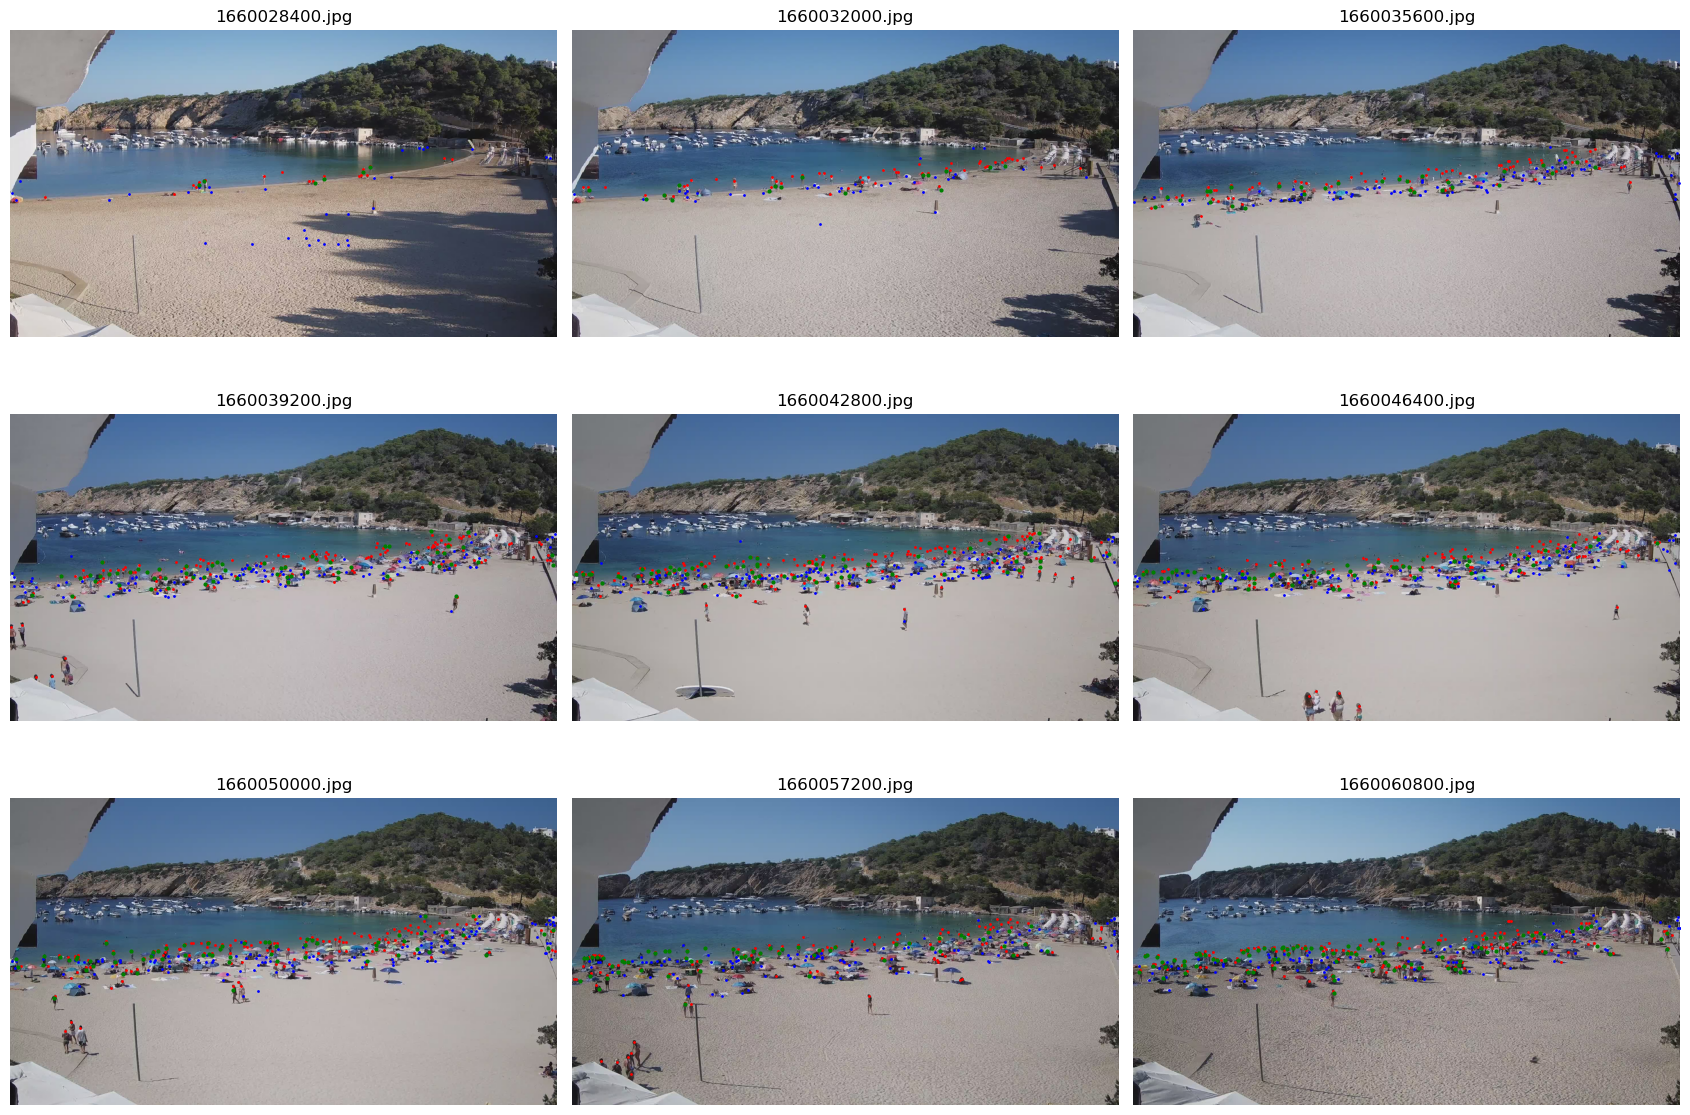

In [6]:
from metrics import calculate_metrics
from laplacian import laplacian
from hist_equalization import hist_equalization
from gaussian_canny import gaussian_canny

from contours import find_contours
from contours import count_contours

rows, cols = 3, 3

# Create a figure and a set of subplots
fig, axes = plt.subplots(rows, cols, figsize=(17, 12))
axes = axes.flatten()

# Itering over the images
idx = 0
for img_name, img_labels in imgs_with_labels.items():
    if img_name not in imgs:
        continue

    if img_name == "1660021200.jpg":
        continue

    diff = calculate_image_difference(path_imgs, img_name, clean_img_name)

    # diff = cv2.absdiff(img, clean_img)
    img_without_background = remove_background(diff, 64)

    # Apply a pre-processing option: Gaussian-Canny;
    edges = gaussian_canny(img_without_background)

    #Laplacian filtering;
    #edges = laplacian(img_without_background)

    # or Histogram equalization
    #edges = hist_equalization(img_without_background)
    

    # Find the contours
    contours = find_contours(edges, min_area=1, max_area=150)
    
    # Count the countours
    predicted_labels, people_count = count_contours(contours)

    # Read the img that we want to plot
    img = cv2.cvtColor(cv2.imread(os.path.join(path_imgs, img_name)), cv2.COLOR_BGR2RGB)

    ax = axes[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"{img_name}")
    ax.axis('off')
    
    # Draw the predicted_labels
    for label in predicted_labels:
        ax.scatter(int(label["label_x"]), int(label["label_y"]), s=1, c='blue')

    # Draw the img_labels
    for label in img_labels:
        ax.scatter(int(label["label_x"]), int(label["label_y"]), s=1, c='red')
    

    near_points = get_near_points_kdtree(predicted_labels, img_name, threshold=20)

    for point in near_points:
        ax.scatter(int(point["label_x"]), int(point["label_y"]), s=4, c='green')

    precision, recall, f1_score, accuracy, mse = calculate_metrics(predicted_labels, imgs_with_labels, img_name, threshold=20)

    print(f"{img_name}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1_score:.2f}, Acc: {accuracy:.2f}, MSE: {mse:.2f}")
    # print(f"Predicted: {len(predicted_labels)}, Real: {len(img_labels)}, Corrected: {len(near_points)}")
    # print(f"Accuracy of predicte with the Real: {(len(near_points) / len(img_labels)):.2f}")
    # print("")
    idx += 1
    if idx >= rows * cols:
        break

plt.tight_layout()
plt.show()